<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно.


---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>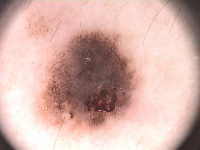</td><td>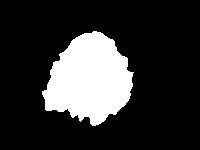</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! wget https://www.dropbox.com/s/uj2qjk4efk199fp/PH2Dataset.rar

--2021-08-09 16:55:25--  https://www.dropbox.com/s/uj2qjk4efk199fp/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uj2qjk4efk199fp/PH2Dataset.rar [following]
--2021-08-09 16:55:25--  https://www.dropbox.com/s/raw/uj2qjk4efk199fp/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee84bc4e9b7728ee01dca1eddf.dl.dropboxusercontent.com/cd/0/inline/BT7QvXlqZO6bvS5QBdbzraNuZgsUYhVE1GV4YLZ612k7dL5GOAIEEq8g9jZ5W1ge3hCrhs9kB68U4Xone2EhhRVh8aMDIXlo-I2sYqOtCOawjeqSzxmBzd1F21gaHyxNo24ktR8beg2PP4b1jU5MDe6m/file# [following]
--2021-08-09 16:55:25--  https://ucee84bc4e9b7728ee01dca1eddf.dl.dropboxusercontent.com/cd/0/inline/BT7QvXlqZO6bvS5QBdbzraNuZgsUYhVE1GV4YLZ612k7dL5GOAIEEq8g9jZ5W1ge3hCrhs9kB68U4Xone2Eh

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

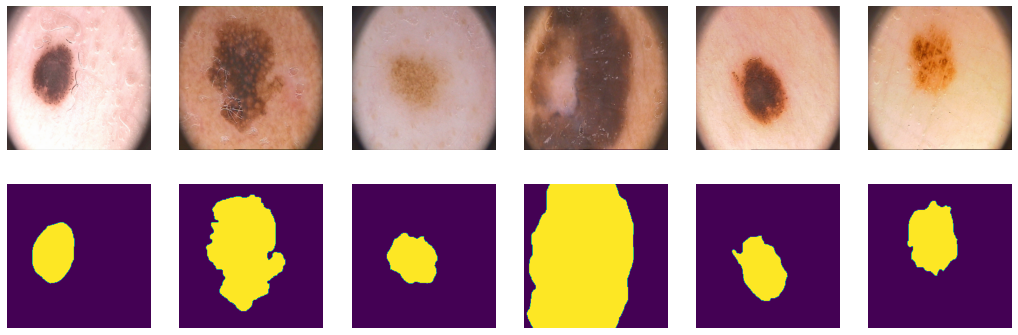

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

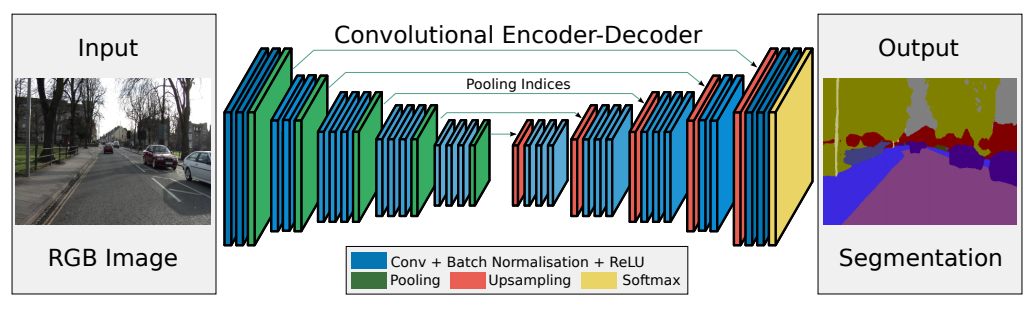

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import random

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
SEED = 54

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # encoder
        e0, indexes_0 = self.pool(self.enc_conv0(x))
        e1, indexes_1 = self.pool(self.enc_conv1(e0))
        e2, indexes_2 = self.pool(self.enc_conv2(e1))
        e3, indexes_3 = self.pool(self.enc_conv3(e2))

        # decoder
        d0 = self.dec_conv0(self.unpool(e3, indexes_3))
        d1 = self.dec_conv1(self.unpool(d0, indexes_2))
        d2 = self.dec_conv2(self.unpool(d1, indexes_1))
        d3 = self.dec_conv3(self.unpool(d2, indexes_0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1) #.byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None,
          loss_name="Loss"):
    X_val, Y_val = next(iter(data_val))

    train_loss = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu

        if scheduler:
            scheduler.step()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(train_loss) + 1), train_loss)
    plt.xticks(range(1, len(train_loss) + 1, 2), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(loss_name, fontsize=14)
    plt.show()
    return train_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [17]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [18]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [19]:
def display_loss(data, loss_type='Train'):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(data)), data)
    plt.title('{} loss'.format(loss_type))
    plt.show()

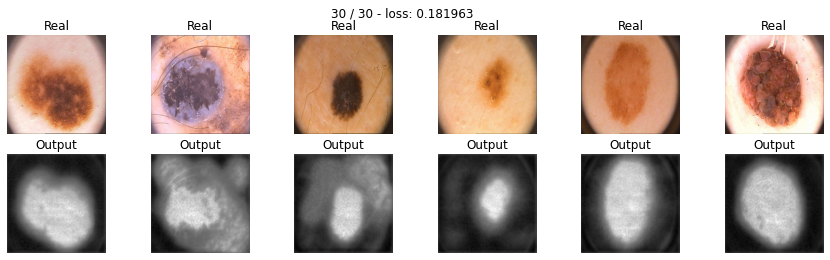

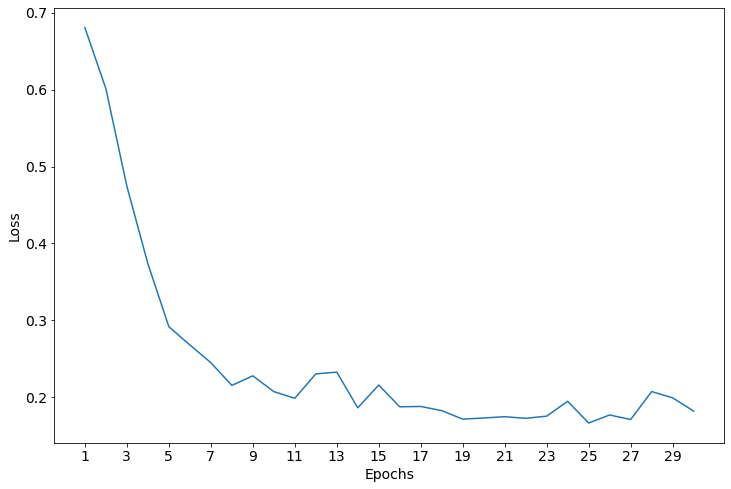

In [20]:
model = SegNet().to(device)

max_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = bce_loss
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
segnet_bce = train(model, optimizer, criterion, max_epochs, data_tr, data_val, scheduler)

In [21]:
score_model(model, iou_pytorch, data_val)

0.7440710961818695

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [22]:
def dice_loss(y_pred, y_real, smooth=1, p=2):
    y_pred = y_pred.view(-1).sigmoid()
    y_real = y_real.view(-1)
    num = torch.sum(torch.mul(y_pred, y_real)) + smooth
    den = torch.sum(y_pred + y_real) + smooth
    loss = 1 - 2. * num / den
    return loss.mean()

Проводим тестирование:

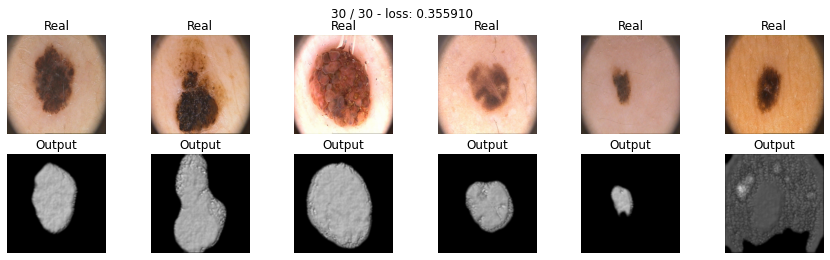

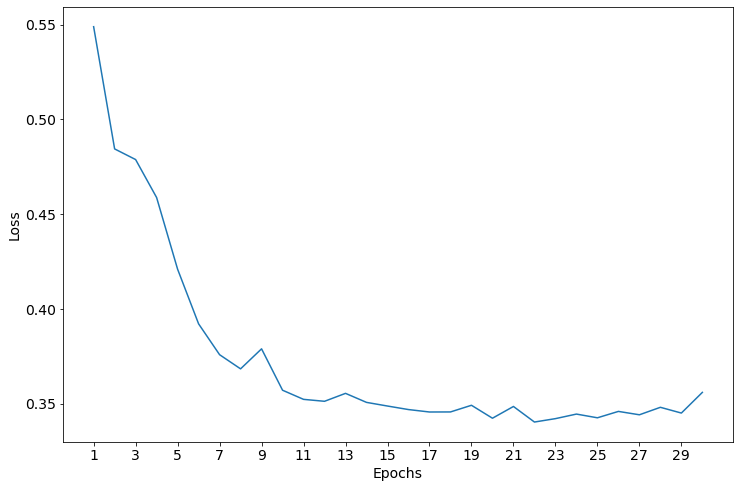

In [23]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [24]:
score_model(model_dice, iou_pytorch, data_val)

0.7294577956199646

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [25]:
def focal_loss(y_pred, y_real, alpha=0.25, gamma=2, smooth=1):
    y_pred = y_pred.sigmoid()

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    BCE = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return loss

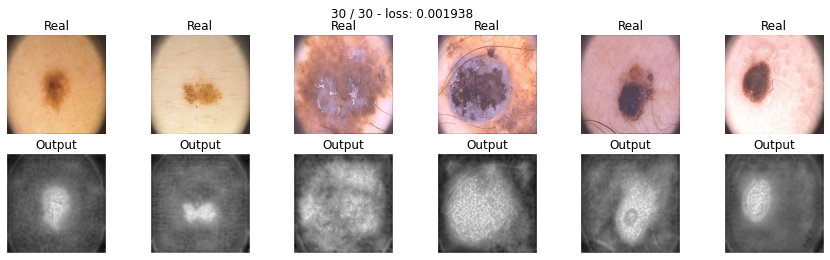

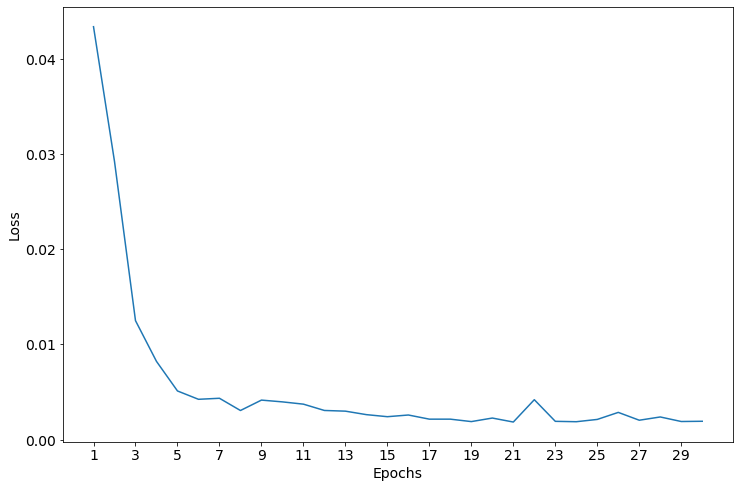

In [27]:
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_focal.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
segnet_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [28]:
score_model(model_focal, iou_pytorch, data_val)

0.7334414124488831

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [29]:
def TVLoss(y_pred, y_real, alpha=0.5, smooth=1):
    y_pred = y_pred.sigmoid()

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    tp = (y_pred * y_real).sum()
    fp = ((1 - y_real) * y_pred).sum()
    fn = (y_real * (1 - y_pred)).sum()

    tversky = (tp + smooth) / (tp + alpha * fp + (1 - alpha) * fn + smooth)
    return 1 - tversky    

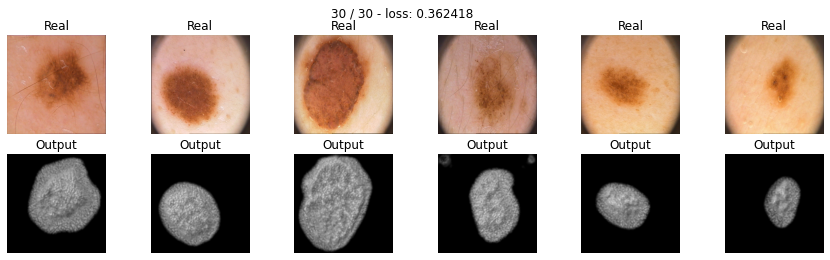

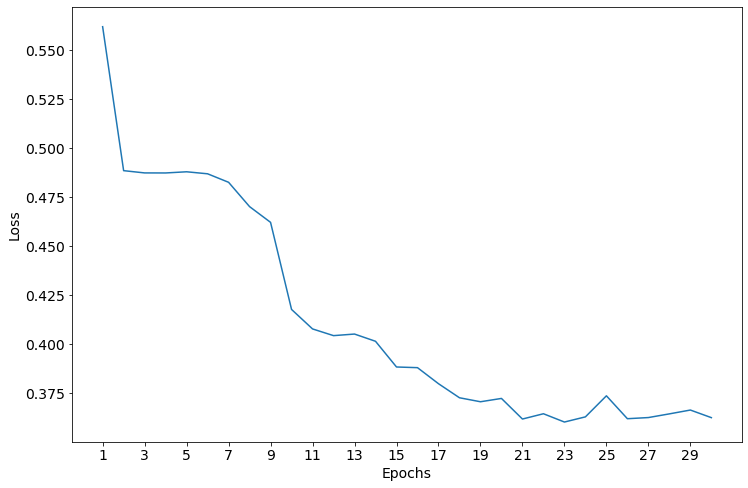

In [30]:
model_tv = SegNet().to(device)
max_epochs = 30
optimaizer = optim.Adam(model_tv.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
segnet_tversky = train(model_tv, optimaizer, TVLoss, max_epochs, data_tr, data_val, scheduler)

In [31]:
score_model(model_tv, iou_pytorch, data_val)

0.6813029646873474

In [32]:
def BoundaryLoss(y_pred, y_real, theta0=3, theta=5):
    n, c, _, _ = y_pred.shape

    pred = y_pred.sigmoid()
    one_hot_real = y_real.detach().clone()

    real_b = nn.MaxPool2d(
        kernel_size=theta0, stride=1, padding=(theta0 - 1) // 2
    )(1 - y_real)
    real_b -= 1 - y_real

    pred_b = nn.MaxPool2d(
        kernel_size=theta0, stride=1, padding=(theta0 - 1) // 2
    )(1 - pred)
    pred_b -= 1 - pred

    # extended boundary map
    real_b_ext = nn.MaxPool2d(
        kernel_size=theta, stride=1, padding=(theta - 1) // 2
    )(real_b)
    pred_b_ext = nn.MaxPool2d(
        kernel_size=theta, stride=1, padding=(theta - 1) // 2
    )(pred_b)

    real_b = real_b.view(n, c, -1)
    pred_b = pred_b.view(n, c, -1)
    real_b_ext = real_b_ext.view(n, c, -1)
    pred_b_ext = pred_b_ext.view(n, c, -1)

    P = torch.sum(pred_b * real_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
    R = torch.sum(pred_b_ext * real_b, dim=2) / (torch.sum(real_b, dim=2) + 1e-7)

    BF1 = 2 * P * R / (P + R + 1e-7)
    loss = torch.mean(1 - BF1)
    return loss

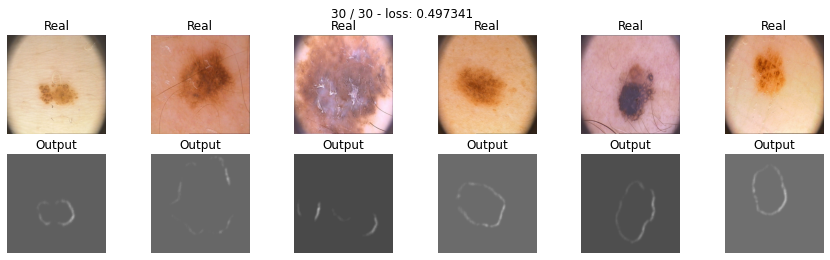

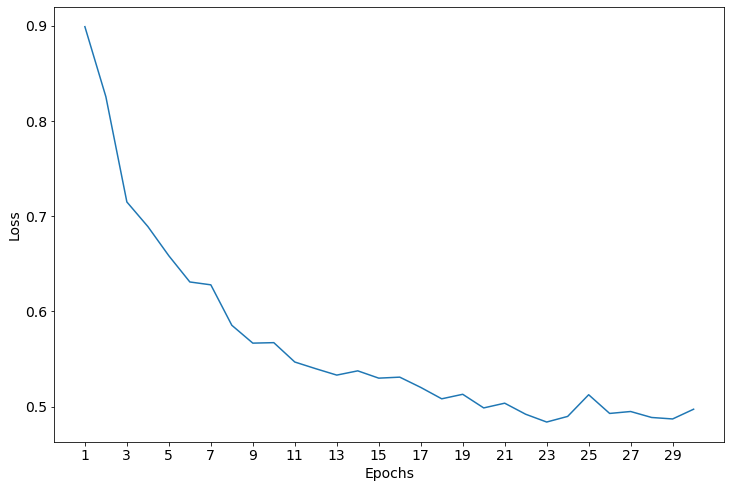

In [51]:
model_boundary = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_boundary.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
_ = train(model_boundary, optimaizer, BoundaryLoss, max_epochs, data_tr, data_val,
          scheduler)

In [34]:
def bce_with_boundary(y_pred, y_real, alpha=1):
    return bce_loss(y_pred, y_real) + alpha * BoundaryLoss(y_pred, y_real)

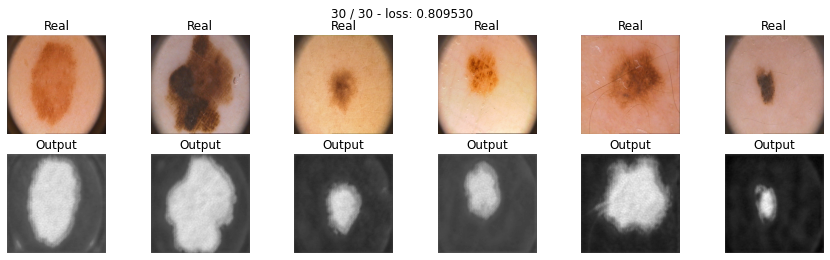

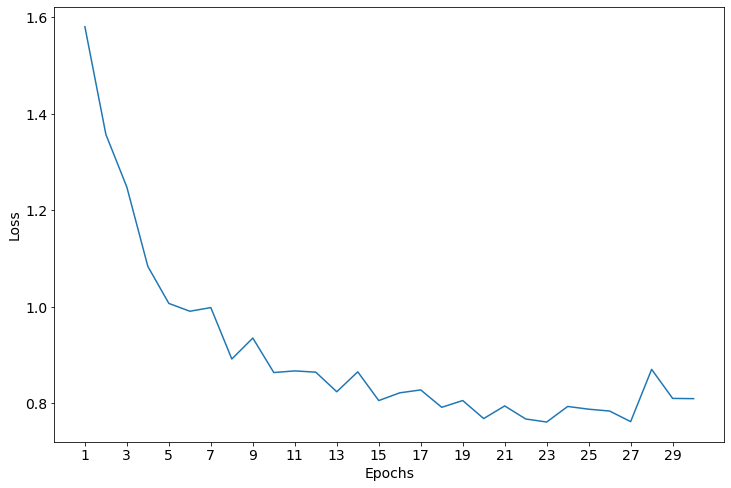

In [35]:
model_bce_boundary = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_bce_boundary.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
segnet_bce_boundary = train(model_bce_boundary, optimaizer, bce_with_boundary,
                            max_epochs, data_tr, data_val, scheduler)

In [36]:
score_model(model_bce_boundary, iou_pytorch, data_val)

0.7511143088340759

In [37]:
def ssim_loss(y_pred, y_real, c1=1e-8, c2=1e-7):
    y_pred = y_pred.sigmoid()
    mu_pred = torch.mean(y_pred)
    mu_real = torch.mean(y_real)
    sigm_pred = torch.var(y_pred)
    sigm_real = torch.var(y_real)

    covariance = torch.mean((y_real - mu_real * y_real) * (y_pred - mu_pred * y_pred))

    s1 = (2 * mu_real * mu_pred + c1) / (torch.pow(mu_real, 2) + torch.pow(mu_pred, 2) + c1)
    s2 = (2 * covariance + c2) / (sigm_real + sigm_pred + c2)
    loss = (1 - s1 * s2) / 2
    return loss.mean()

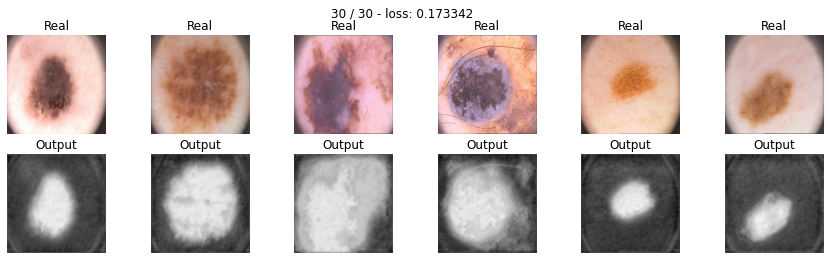

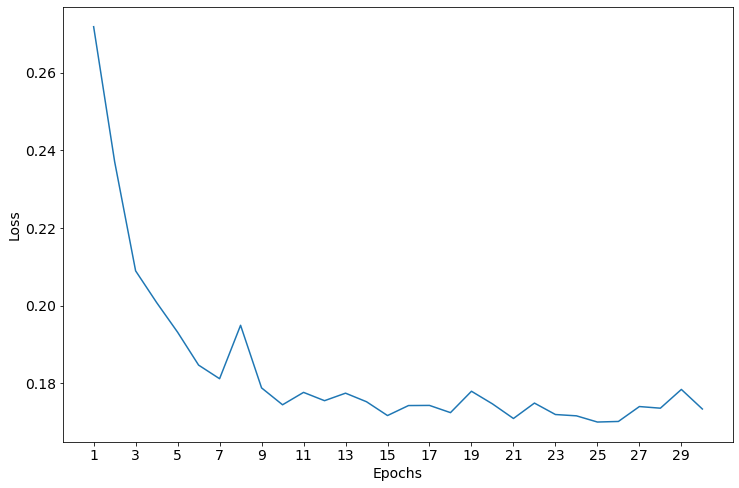

In [38]:
model_ssim = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_ssim.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
segnet_ssim = train(model_ssim, optimaizer, ssim_loss, max_epochs, data_tr, data_val, scheduler)

In [39]:
score_model(model_ssim, iou_pytorch, data_val)

0.7221628725528717

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

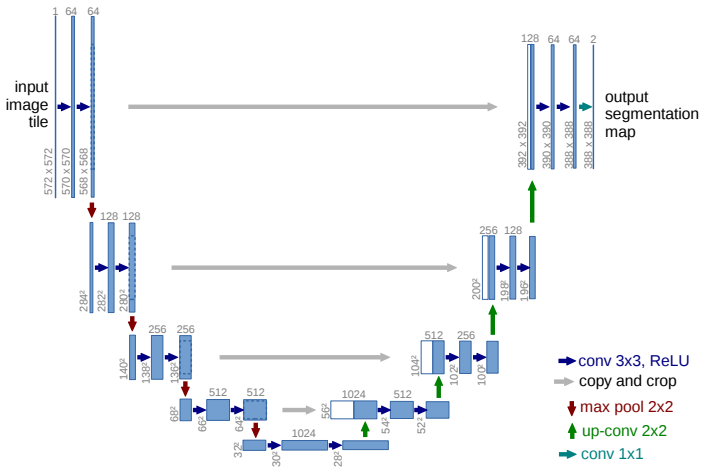

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [40]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))

In [41]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = double_conv(3, 64)
        self.enc_conv1 = double_conv(64, 128)
        self.enc_conv2 = double_conv(128, 256)
        self.enc_conv3 = double_conv(256, 512)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.dec_conv0 = double_conv(2 * 512, 256)
        self.dec_conv1 = double_conv(2 * 256, 128)
        self.dec_conv2 = double_conv(2 * 128, 64)
        self.dec_conv3 = double_conv(64 * 2, 64)
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool(e0))
        e2 = self.enc_conv2(self.pool(e1))
        e3 = self.enc_conv3(self.pool(e2))
        
        # bottleneck
        b = self.bottleneck_conv(self.pool(e3))

        # decoder
        d0 = self.upsample(b)
        d0 = torch.cat((d0, e3), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample(d0)
        d1 = torch.cat((d1, e2), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample(d1)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample(d2)
        d3 = torch.cat((d3, e0), dim=1)
        d3 = self.dec_conv3(d3)
        return self.out_conv(d3)

In [42]:
unet_model = UNet().to(device)

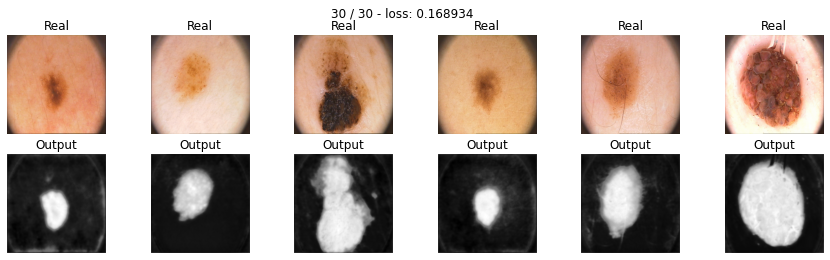

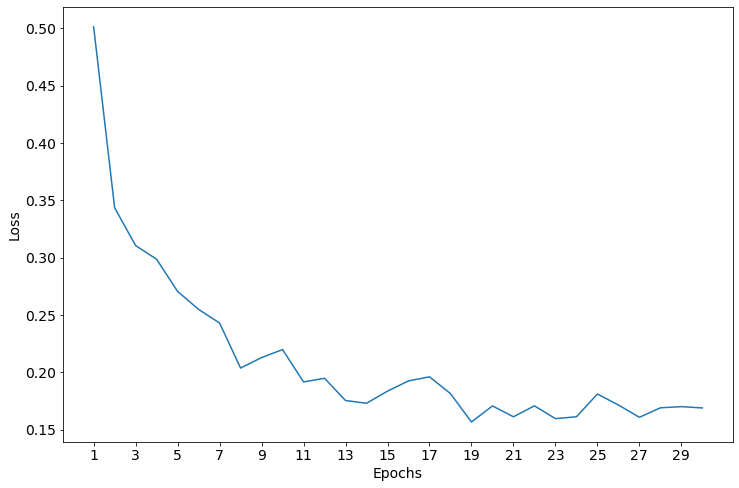

In [43]:
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
unet1_bce = train(unet_model, optimaizer, bce_loss, 30, data_tr, data_val, scheduler)

In [44]:
score_model(unet_model, iou_pytorch, data_val)

0.7800107598304749

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [45]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = double_conv(3, 64)
        self.downsample0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2,
                               stride=2)
        self.enc_conv1 = double_conv(64, 128)
        self.downsample1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2,
                               stride=2)
        self.enc_conv2 = double_conv(128, 256)
        self.downsample2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2,
                               stride=2)
        self.enc_conv3 = double_conv(256, 512)
        self.downsample3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2,
                               stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                            kernel_size=2, stride=2)
        self.dec_conv0 = double_conv(2 * 512, 256)
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                            kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = double_conv(2 * 256, 128)
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                            kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = double_conv(2 * 128, 64)
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = double_conv(64 * 2, 64)
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.downsample0(e0))
        e2 = self.enc_conv2(self.downsample1(e1))
        e3 = self.enc_conv3(self.downsample2(e2))
        
        # bottleneck
        b = self.bottleneck_conv(self.downsample3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat((d0, e3), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0), dim=1)
        d3 = self.dec_conv3(d3)
        return self.out_conv(d3)

In [46]:
unet2_model = UNet2().to(device)

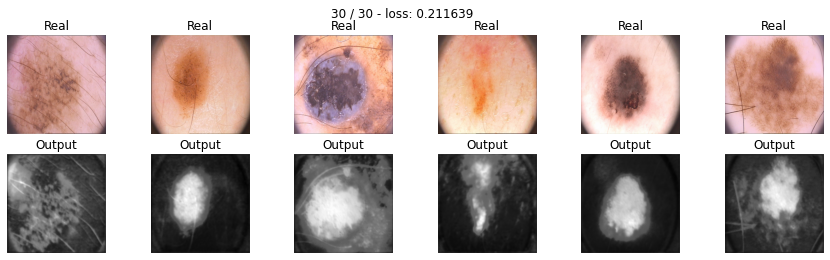

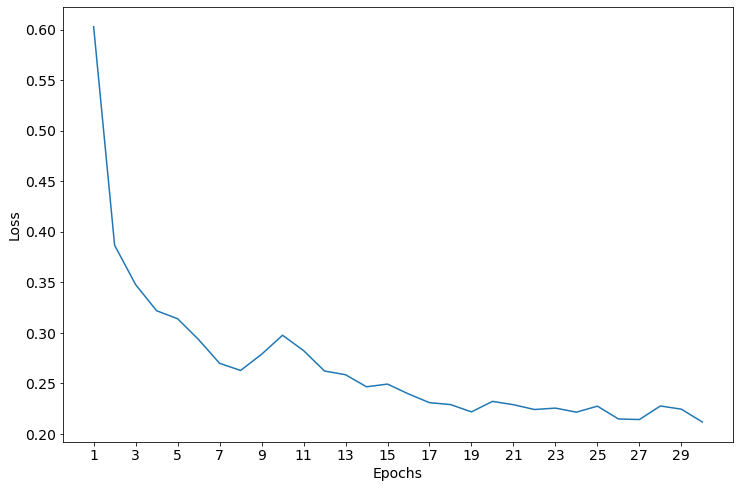

In [47]:
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.1)
unet2_bce = train(unet2_model, optimaizer, bce_loss, 30, data_tr, data_val, scheduler)

In [48]:
score_model(unet2_model, iou_pytorch, data_val)

0.7345881462097168

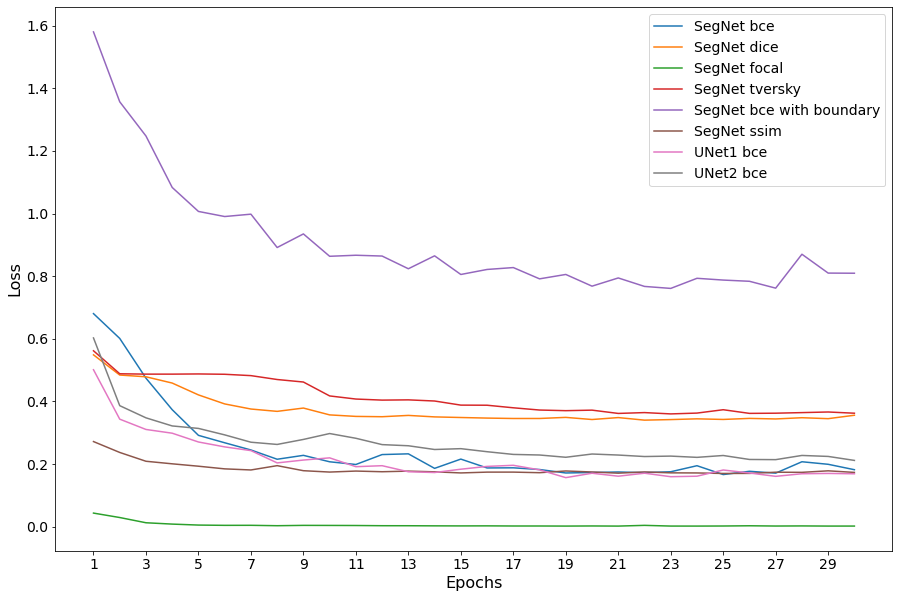

In [50]:
x = range(1, len(segnet_bce) + 1)
plt.figure(figsize=(15, 10))
plt.plot(x, segnet_bce, label='SegNet bce')
plt.plot(x, segnet_dice, label='SegNet dice')
plt.plot(x, segnet_focal, label='SegNet focal')
plt.plot(x, segnet_tversky, label='SegNet tversky')
plt.plot(x, segnet_bce_boundary, label='SegNet bce with boundary')
plt.plot(x, segnet_ssim, label='SegNet ssim')
plt.plot(x, unet1_bce, label='UNet1 bce')
plt.plot(x, unet2_bce, label='UNet2 bce')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(x[::2], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()